<a href="https://colab.research.google.com/github/piotrbar250/DNN-MIMUW-2025/blob/main/docs/DNN-Lab-1-MSLE-student-version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img src='https://drive.google.com/uc?id=1_utx_ZGclmCwNttSe40kYA6VHzNocdET' height="60"></center>

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<center><img src='https://drive.google.com/uc?id=1BXZ0u3562N_MqCLcekI-Ens77Kk4LpPm'></center>

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej"
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

# Linear regression

In this exercise, you will use linear regression to predict flat (apartment) prices. Training will be handled via gradient descent. We will:
* have multiple features (i.e. variables used to make the prediction),
* employ some basic feature engineering,
* work with a non-standard loss function.

Let's start by obtaining the data.

In [2]:
!wget --no-verbose -O mieszkania.csv https://www.dropbox.com/s/zey0gx91pna8irj/mieszkania.csv?dl=1
!wget --no-verbose -O mieszkania_test.csv https://www.dropbox.com/s/dbrj6sbxb4ayqjz/mieszkania_test.csv?dl=1
!head mieszkania.csv mieszkania_test.csv

2025-10-10 08:52:02 URL:https://uc739922ef8264bc0d0059c9d95d.dl.dropboxusercontent.com/cd/0/inline/Cy-wb1kyARdcJqlmcrN7KDdEF053ZPz8YZYMp0WddNX_1z_kX5asdWZCV2uapaDTCj-oGnWaDHNm2EudFEIxZXzz0FKeEw3fRge1NJrwpKTRCFxXicnYOezSL8A8RlpIcgA/file?dl=1 [6211/6211] -> "mieszkania.csv" [1]
2025-10-10 08:52:03 URL:https://ucae7459f26efd20401ac3bb98d8.dl.dropboxusercontent.com/cd/0/inline/Cy-ngtTFnZZWlD8eyExAhDXG9WCvqr_01ZX4mN-bhl7Jt3Abt7whh6-c6hYE9HkdoY9GLOILv4tcUXqIXgBivwRUcr6aOcCErmOawGmhCFFgRJOGWoC_yomW5CQfcnlDoBA/file?dl=1 [6247/6247] -> "mieszkania_test.csv" [1]
==> mieszkania.csv <==
m2,dzielnica,ilość_sypialni,ilość_łazienek,rok_budowy,parking_podziemny,cena
104,mokotowo,2,2,1940,1,780094
43,ochotowo,1,1,1970,1,346912
128,grodziskowo,3,2,1916,1,523466
112,mokotowo,3,2,1920,1,830965
149,mokotowo,3,3,1977,0,1090479
80,ochotowo,2,2,1937,0,599060
58,ochotowo,2,1,1922,0,463639
23,ochotowo,1,1,1929,0,166785
40,mokotowo,1,1,1973,0,318849

==> mieszkania_test.csv <==
m2,dzielnica,ilość_sypialni,ilość_

Each row in the data represents a separate flat. Our goal is to use the data from `mieszkania.csv` to create a model that can predict a flat's price (i.e. `cena`) given its features (i.e. `m2,dzielnica,ilosc_sypialni,...`).

We should use only `mieszkania.csv` (dubbed the training dataset) to make our decisions and create the model. The (only) purpose of `mieszkania_test.csv` is to test our model on **unseen** data.

In [3]:
!head mieszkania.csv mieszkania_test.csv

==> mieszkania.csv <==
m2,dzielnica,ilość_sypialni,ilość_łazienek,rok_budowy,parking_podziemny,cena
104,mokotowo,2,2,1940,1,780094
43,ochotowo,1,1,1970,1,346912
128,grodziskowo,3,2,1916,1,523466
112,mokotowo,3,2,1920,1,830965
149,mokotowo,3,3,1977,0,1090479
80,ochotowo,2,2,1937,0,599060
58,ochotowo,2,1,1922,0,463639
23,ochotowo,1,1,1929,0,166785
40,mokotowo,1,1,1973,0,318849

==> mieszkania_test.csv <==
m2,dzielnica,ilość_sypialni,ilość_łazienek,rok_budowy,parking_podziemny,cena
71,wolowo,2,2,1912,1,322227
45,mokotowo,1,1,1938,0,295878
38,mokotowo,1,1,1999,1,306530
70,ochotowo,2,2,1980,1,553641
136,mokotowo,3,2,1939,1,985348
128,wolowo,3,2,1983,1,695726
23,grodziskowo,1,1,1975,0,99751
117,mokotowo,3,2,1942,0,891261
65,ochotowo,2,1,2002,1,536499


In [4]:
%matplotlib inline

from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from tqdm.auto import tqdm

NDArray = np.ndarray[Any, Any]

np.set_printoptions(precision=4, suppress=True)
np.random.seed(357)

## Loading and converting data

Let's start by loading the data and showing the range of prices we're working with.

In [5]:
def load(path: str) -> tuple[NDArray, NDArray]:
    """
    Returns (x, y) where:
    - x: input features, shape (n_apartments, n_features)
    - y: price, shape (n_apartments,)
    """
    data = pd.read_csv(path)
    y = data["cena"].to_numpy()
    x = data.loc[:, data.columns != "cena"].to_numpy()
    return x, y

In [6]:
x_train, y_train = load("mieszkania.csv")
x_test, y_test = load("mieszkania_test.csv")

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(200, 6) (200,)
(200, 6) (200,)


In [7]:
x_train[0]
y_train[0]

np.int64(780094)

In [8]:
print(np.min(y_train), np.max(y_train), np.mean(y_train))

102572 1102309 507919.49


In [9]:
x_train[:3]

array([[104, 'mokotowo', 2, 2, 1940, 1],
       [43, 'ochotowo', 1, 1, 1970, 1],
       [128, 'grodziskowo', 3, 2, 1916, 1]], dtype=object)

We'll need to convert features to floats.

In [10]:
# Convert column 1 from str to (ordinal) int.
# (One-hot encoding would be better, but ordinal is OK for today.)
label_encoder = LabelEncoder()
label_encoder.fit(x_train[:, 1])
x_train[:, 1] = label_encoder.transform(x_train[:, 1])
x_test[:, 1] = label_encoder.transform(x_test[:, 1])

# Convert ints to float.
x_train = x_train.astype(np.float64)
x_test = x_test.astype(np.float64)

In [11]:
x_train[:3]

array([[ 104.,    1.,    2.,    2., 1940.,    1.],
       [  43.,    2.,    1.,    1., 1970.,    1.],
       [ 128.,    0.,    3.,    2., 1916.,    1.]])

## The loss and constant models

Our predictions should minimize the so-called *mean squared logarithmic error*:
$$
MSLE = \frac{1}{n} \sum_{i=1}^n (\log(1+y_i) - \log(1+p_i))^2,
$$
where $y_i$ is the ground truth, and $p_i$ is our prediction.

Let's implement the loss function first.

In [12]:
def mse(ys: NDArray, ps: NDArray) -> np.float64:
    assert ys.shape == ps.shape
    # return np.mean((ys - ps) * (ys - ps))
    return np.mean((ys - ps) ** 2)

In [13]:
def msle(ys: NDArray, ps: NDArray) -> np.float64:
    assert ys.shape == ps.shape
    #################################
    # TODO: Implement this function #
    #################################
    return np.mean((np.log(1 + ys) - np.log(1 + ps)) ** 2)

The simplest model is predicting the same constant for each instance. Test your implementation of msle against outputing the mean price.

In [14]:
###################################################
# TODO: Compute msle for outputing the mean price #
###################################################

mean_price = np.mean(y_train)
mse(y_train, np.zeros_like(y_train) + mean_price)
msle(y_train, np.zeros_like(y_train) + mean_price)
msle(y_test, np.zeros_like(y_test) + mean_price)

np.float64(0.4284115392580848)

Recall that outputing the mean minimizes $MSE$. However, we're now dealing with $MSLE$.

Think of a constant that should result in the lowest $MSLE$.

435817.6666666667 0.3649917421472992


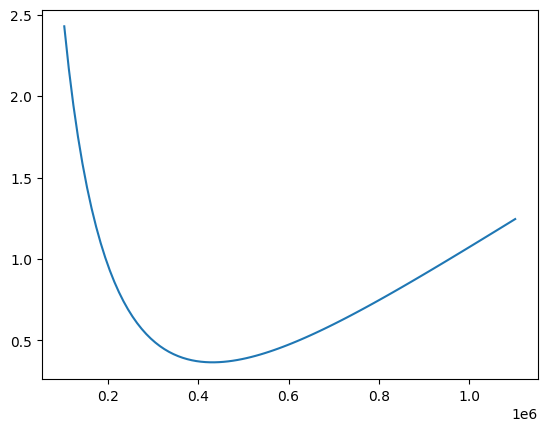

In [15]:
#############################################
# TODO: Find this constant and compute msle #
#############################################

#find c such that msle(y_train, c)
#msle(y,c) = mse(f(y), f(c)) gdzie f(y) = log(1+y)
#find d minimizing mse(f(y), d)
#d=np.mean(f(y)) = np.mean(log(1+y))
#f = f(c) = log(1+c)
#log(1+c) = np.mean(log(1+y))
#c = exp(d) -1

#c = exp(np.mean(np.log(1+y))) - 1

def example_plot():
  costs = np.linspace(np.min(y_train), np.max(y_train), 100)
  losses = []
  for c in costs:
    losses.append(msle(y_train, np.zeros_like(y_train) + c))

  best_cost = costs[np.argmin(losses)]
  best_loss = np.min(losses)

  plt.plot(costs, losses)
  plt.plot([best_cost], best_loss)

  print(best_cost, best_loss)
  minimizer = np.exp(np.mean(np.log(1+y_train)))

example_plot()


In [16]:
np.zeros_like(np.array([1,2]))

array([0, 0])

## Linear regression (standard)

Now, let's implement training of a standard linear regression model via gradient descent.

In [27]:
#my own
def train(
    x: NDArray, y: NDArray, alpha: float = 1e-7, n_iterations: int = 100000
) -> tuple[NDArray, np.float64]:

  print(x.shape)
  # B is number of observations (batchsize)
  # F is number of features
  B, F = x.shape
  weights = np.random.uniform(size=(F,), low=-1/np.sqrt(F), high=1/np.sqrt(F))
  bias = float(np.mean(y))

  for _ in range(n_iterations):
    preds = x @ weights + bias
    grad_preds = -(2/B) * (y - preds)
    grad_bias = np.sum(grad_preds)
    grad_weights = x.T @ grad_preds

    weights -= alpha * grad_weights
    bias -= alpha * grad_bias

  return weights, bias


weights, bias = train(x_train, y_train)
# @ - matmul
preds_test = x_test @ weights + bias # Multiply (B, F) @ (F, ) + (1,)
print("test MSLE:", mse(y_test, preds_test))


(200, 6)
test MSLE: 18455227446.17277


In [25]:
def train(
    x: NDArray, y: NDArray, alpha: float = 1e-7, n_iterations: int = 100000
) -> tuple[NDArray, np.float64]:
    """Linear regression (which optimizes MSE). Returns (weights, bias)."""

    # B is batch size (number of observations).
    # F is number of (input) features.
    B, F = x.shape
    assert y.shape == (B,)

    # TODO #

    weights = np.random.uniform(size=(F,), low=-1/np.sqrt(F), high=1/np.sqrt(F))
    # biases = 0
    biases = np.mean(y)

    for _ in tqdm(range(n_iterations)):
      preds = x_train @ weights + bias
      loss = mse(y_train, preds)



      # weights   -= alpha * grad_weights loss
      # bias       -= alpha * grad_bias loss

      # grad_(pred_i) mse(y_train, preds) = 1/N ((y[i] - pred_i)**2 + ...)
      # grad_(pred_i) mse(y_train, preds) = (2 / B) * (y - preds[i]) (-1)

      #grad_bias mse(y, preds) = sum_i grad_bias pred_i * grad_(preds_i) mse(y.preds) # chainrule!
      #                        = sum_i 1 *

      #                        pred_i = sum_j w_j * x_ij + bias

      #grad_(w_j)              = sum_i grad_(w_j) pred_i * ...
      #

      grad_preds = -(2 / B ) * (y_train - preds) # shape(B,)
      grad_bias = np.sum(grad_preds) # scalar

      grad_weights = x_train.T @ grad_preds # (F, B) @ (B,) = shape(F,)

      weights -= alpha * grad_weights
      bias -= alpha * grad_bias

    return weights, biases



weights, bias = train(x_train, y_train)
# @ - matmul
preds_test = x_train @ weights + bias # Multiply (B, F) @ (F, ) + (1,)
print("test MSLE:", msle(y_test, preds_test))

  0%|          | 0/100000 [00:00<?, ?it/s]

UnboundLocalError: cannot access local variable 'bias' where it is not associated with a value

## Linear regression (MSLE)

Note that the loss function that the algorithms optimizes (i.e $MSE$) differs from $MSLE$. We've already seen that this may result in a suboptimal solution.

How can you change the setting so that we optimze $MSLE$ instead?

Hint:
<sub><sup><sub><sup><sub><sup>
Be lazy. We don't want to change the algorithm.
Use the chain rule and previous computations to get formulas for the gradient.
</sup></sub></sup></sub></sup></sub>

In [ ]:
def train_msle(
    x: NDArray, y: NDArray, alpha: float = 1e+4, n_iterations: int = 50000
) -> tuple[NDArray, NDArray]:
    """Gradient descent for MSLE."""
    B, F = x.shape
    assert y.shape == (B,)

    #############################################
    # TODO: Optimize msle and compare the error #
    #############################################
    weights = np.random.uniform(size=(F,), low=-1/np.sqrt(F), high=1/np.sqrt(F))
    # biases = 0
    biases = np.mean(y)

    for _ in tqdm(range(n_iterations)):
      preds = x_train @ weights + bias
      loss = mse(y_train, preds)

      #f(y) = log(y+1)
      # grad_(pred_i) msle(y_train, preds) = grad_predsi mse(f(y), f(pred))
      # = grad_p f(p[i]) * grads_z mse(f(y), z) w punkcie z  = f(p)
      # = 1 / (y + 1) * (2/B) * 2 * (f(y[i] - f(p[i])) (-1)

      grad_preds = -(2 / B ) * (1 / (y_train+1)) * (np.log(y_train+1) - np.log(preds+1))

      # grad_(pred_i) mse(y_train, preds) = (2 / B) * (y - preds[i]) (-1)

      #grad_bias mse(y, preds) = sum_i grad_bias pred_i * grad_(preds_i) mse(y.preds) # chainrule!
      #                        = sum_i 1 *

      #                        pred_i = sum_j w_j * x_ij + bias

      #grad_(w_j)              = sum_i grad_(w_j) pred_i * ...
      #

      grad_bias = np.sum(grad_preds) # scalar

      grad_weights = x_train.T @ grad_preds # (F, B) @ (B,) = shape(F,)

      weights -= alpha * grad_weights
      bias -= alpha * grad_bias

    return weights, biases


weights, bias = train_msle(x_train, y_train)
preds_test =  # TODO #
print("test MSLE: ", msle(y_test, preds_test))

#gradient sredniej kwadrowej jaki on wychodzi

SyntaxError: invalid syntax (ipython-input-3866069702.py, line 23)

## Feature engineering

Without any feature engineering our model approximates the price as a linear combination of original features:
$$
\text{price} \approx w_1 \cdot \text{area} + w_2 \cdot \text{district} + \dots.
$$
Let's now introduce some interactions between the variables. For instance, let's consider a following formula:
$$
\text{price} \approx w_1 \cdot \text{area} \cdot \text{avg. price in the district per sq. meter} + w_2 \cdot \dots + \dots.
$$
Here, we model the price with far greater granularity, and we may expect to see more acurate results.

Add some feature engineering to your model. Be sure to play with the data and not with the algorithm's code.

Think how to make sure that your model is capable of capturing the $w_1 \cdot \text{area} \cdot \text{avg. price...}$ part, without actually computing the averages.

Note that you may need to change the learning rate substantially.

Hint:
<sub><sup><sub><sup><sub><sup>
Is having a binary encoding for each district and multiplying it by area enough?
</sup></sub></sup></sub></sup></sub>

Hint 2:
<sub><sup><sub><sup><sub><sup>
Why not multiply everything together? I.e. (A,B,C) -> (AB,AC,BC).
</sup></sub></sup></sub></sup></sub>

In [ ]:
###############################################
# TODO: Implement the feature engineering part #
###############################################

In [ ]:
##############################################################
# TODO: Test your solution on the training and test datasets #
##############################################################

# Validation

In this exercise you will implement a validation pipeline: split the non-test set into train and validation sets and select the best model based on validation results.

So far you tested your model against the training and test datasets. As you should observe, there's a gap between the results. By validating your model, you should be able to better anticipate the test time performance and compare different models and hyperparameters on datasets they are not over-fitted to.

Implement the basic validation method, i.e. a random split. Test it with your model from Exercise MSLE.

In [ ]:
x_train_val, y_train_val = x_train, y_train
x_test, y_test = x_test, y_test


def random_split(
    x: NDArray, y: NDArray, val_ratio: float = 0.2
) -> tuple[tuple[NDArray, NDArray], tuple[NDArray, NDArray]]:
    """Returns (x_train, y_train), (x_val, y_val)."""

    idxs = np.random.permutation(len(x))

    ######################################################
    # TODO: Implement the basic validation split method. #
    ######################################################




(x_train, y_train), (x_val, y_val) = random_split(x_train_val, y_train_val)

len(x_train), len(x_val), len(x_test)

(160, 40, 200)

In [ ]:
#############################################################
# TODO: compare MSLE on training, validation, and test sets #
#############################################################

## Cross-validation

To make the random split validation reliable, a significant chunk of training data may be needed. To get over this problem, one may apply cross-validation.

![alt-text](https://chrisjmccormick.files.wordpress.com/2013/07/10_fold_cv.png)

Let's now implement the method. Make sure that:
* number of partitions is a parameter,
* the method is not limited to `mieszkania.csv`,
* the method is not limited to one specific model.

In [ ]:
####################################
# TODO: Implement cross-validation #
####################################
def kfold(x: NDArray, y: NDArray, n_folds: int = 5, shuffle: bool = False) -> list[float]:
    """Returns losses for each fold."""



losses = kfold(x_train_val, y_train_val, n_folds=3, shuffle=False)
print(f"k-fold loss: {np.mean(losses):.4f} +- {np.std(losses):.4f}")


## Investigating input data

Recall that sometimes validation may be tricky, e.g. significant class imbalance, having a small number of subjects, geographically clustered instances...

What could in theory go wrong here with random, unstratified partitions? Think about potential solutions and investigate the data in order to check whether these problems arise here.

In [ ]:
##############################
# TODO: Investigate the data #
##############################